In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import seaborn as sns

import itertools

from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf

In [7]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [8]:
y_train = train['label'].astype('float32')
X_train = train.drop(['label'], axis=1).astype('int32')
X_test = test.astype('float32')
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (28000, 784))

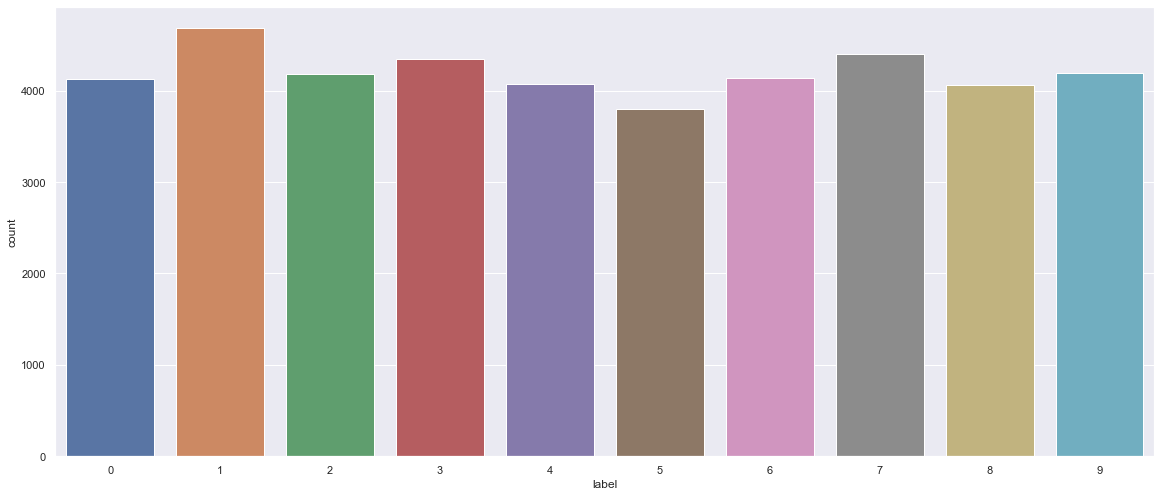

In [9]:
sns.set(rc={'figure.figsize':(19.7,8.27)})
sns.countplot(x='label', data=train);

In [10]:
# Data normalization
X_train = X_train/255
X_test = X_test/255

In [11]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
X_train.shape, X_test.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [12]:
# one-hot encoding
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 10)
y_train.shape

(42000, 10)

In [13]:
print(train['label'].head())
y_train[0:5,:]

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

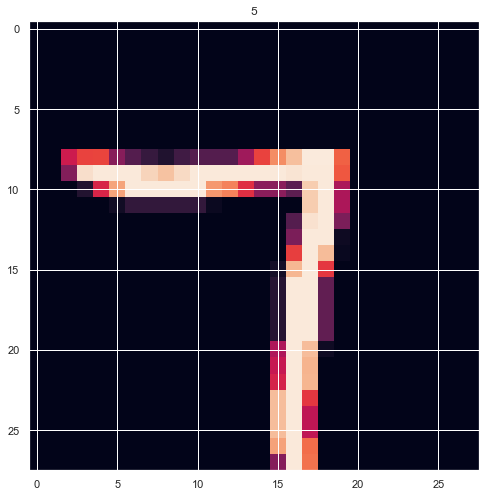

In [15]:
plt.imshow(X_train[9][:,:,0])
plt.title(y_train[1].argmax());

In [17]:
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import keras
from keras import backend as K

In [18]:
# Building a CNN model
input_shape = (28,28,1)
X_input = Input(input_shape)

# layer 1
x = Conv2D(64,(3,3),strides=(1,1),name='layer_conv1',padding='same')(X_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)
# layer 2
x = Conv2D(32,(3,3),strides=(1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)
# layer 3
x = Conv2D(32,(3,3),strides=(1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2), name='maxPool3')(x)
# fc
x = Flatten()(x)
x = Dense(64,activation ='relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation ='relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(10,activation ='softmax',name='fc2')(x)

conv_model = Model(inputs=X_input, outputs=x, name='Predict')
conv_model.summary()

Model: "Predict"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 layer_conv1 (Conv2D)        (None, 28, 28, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 64)        0         
                                                                 
 maxPool1 (MaxPooling2D)     (None, 14, 14, 64)        0         
                                                                 
 layer_conv2 (Conv2D)        (None, 14, 14, 32)        18464     
                                                           

In [19]:
# Adam optimizer
conv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = conv_model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_cv,y_cv))

Epoch 1/10
378/378 [==============================] - 129s 339ms/step - loss: 0.5783 - accuracy: 0.8213 - val_loss: 1.7285 - val_accuracy: 0.4562
Epoch 2/10
378/378 [==============================] - 121s 319ms/step - loss: 0.1503 - accuracy: 0.9584 - val_loss: 0.1012 - val_accuracy: 0.9690
Epoch 3/10
378/378 [==============================] - 119s 316ms/step - loss: 0.1057 - accuracy: 0.9702 - val_loss: 0.0870 - val_accuracy: 0.9767
Epoch 4/10
378/378 [==============================] - 123s 325ms/step - loss: 0.0822 - accuracy: 0.9777 - val_loss: 0.0588 - val_accuracy: 0.9831
Epoch 5/10
378/378 [==============================] - 140s 370ms/step - loss: 0.0721 - accuracy: 0.9808 - val_loss: 0.0836 - val_accuracy: 0.9779
Epoch 6/10
378/378 [==============================] - 155s 409ms/step - loss: 0.0632 - accuracy: 0.9823 - val_loss: 0.0574 - val_accuracy: 0.9852
Epoch 7/10
378/378 [==============================] - 136s 360ms/step - loss: 0.0567 - accuracy: 0.9843 - val_loss: 0.0988 -

In [20]:
y_pred = conv_model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
my_submission = pd.DataFrame({'ImageId': list(range(1, len(y_pred)+1)), 'Label': y_pred})
my_submission.to_csv('submission.csv', index=False)

875/875 [==============================] - 36s 41ms/step


In [22]:
sub=pd.read_csv('submission.csv')

In [23]:
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


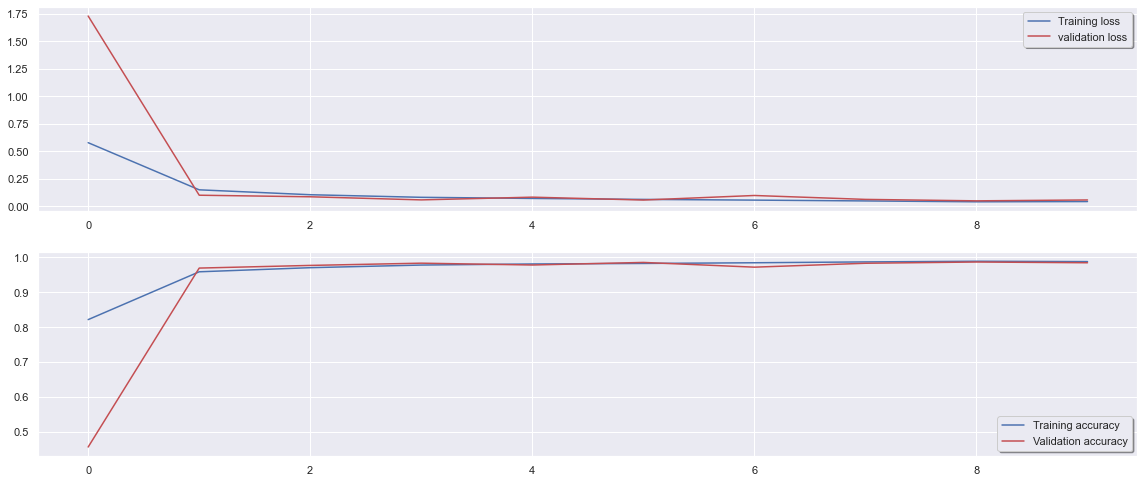

In [24]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

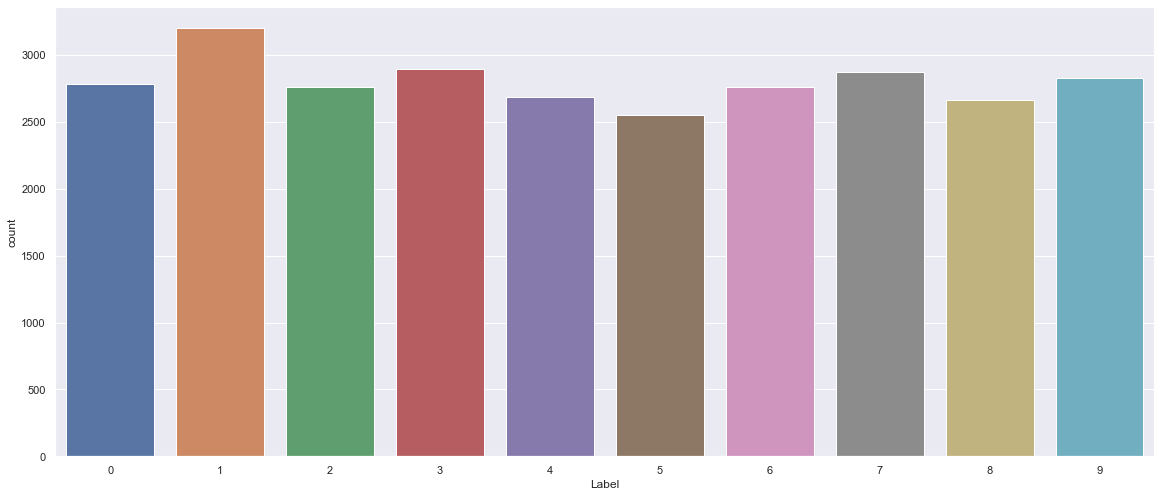

In [25]:
sns.set(rc={'figure.figsize':(19.7,8.27)})
sns.countplot(x='Label', data=sub);